# Load libraries

In [86]:
!pip install gensim
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim

# Load data

In [88]:
corpus = pd.read_excel('./data/cleaned_corpus_current.xlsx')
corpus.head()

,title,link,date_published,text,like_count,reply_parent_id,source,cleaned_text
0,NaN,https://www.rappler.com/philippines/dpwh-manue...,2025-08-31 17:02:21,NaN,NaN,NaN,rappler,NaN
1,NaN,https://www.rappler.com/philippines/dpwh-suspe...,2025-09-03 11:20:56,NaN,NaN,NaN,rappler,NaN
2,NaN,https://www.rappler.com/philippines/flood-cont...,2025-09-04 15:01:13,NaN,NaN,NaN,rappler,NaN
3,NaN,https://www.rappler.com/philippines/coa-holds-...,2025-09-09 10:47:37,NaN,NaN,NaN,rappler,NaN
4,NaN,https://www.rappler.com/philippines/visayas/ma...,2025-08-14 15:36:45,NaN,NaN,NaN,rappler,NaN


# Static Word Embedding

In [89]:
# Tokenize the text
corpus = corpus.dropna(subset=['cleaned_text'])
corpus['tokenized_text'] = corpus['cleaned_text'].apply(lambda x: x.split())

In [90]:
display(
  corpus['cleaned_text'].head()
)

display(
  corpus['tokenized_text'].head()
)

12                                     iyak ddshit iyak
13          pak u administrasyon nato empyerno sigurado
14    silbi ici pera pera taongbayan inspector kanil...
15                                     iyak ddshit iyak
17                                     iyak ddshit iyak
Name: cleaned_text, dtype: object

12                                 [iyak, ddshit, iyak]
13    [pak, u, administrasyon, nato, empyerno, sigur...
14    [silbi, ici, pera, pera, taongbayan, inspector...
15                                 [iyak, ddshit, iyak]
17                                 [iyak, ddshit, iyak]
Name: tokenized_text, dtype: object

In [91]:
model = gensim.models.Word2Vec(corpus['tokenized_text'],
                               vector_size=100,  # Dimension of the word vectors
                               min_count=1,    # Ignores all words with total frequency lower min_count
                               sg=0,           # Training algorithm: 0 for CBOW; 1 for Skip-gram
                               window=5,       # Maximum distance between the current & predicted word within a sentence
                               workers=4,      # Number of workers to use for training
                               epochs=10       # Number of iterations over the corpus
                               )

model.save('word2vec.model')

## Inspecting the word2vec

In [92]:
# Load the model
model = gensim.models.Word2Vec.load('word2vec.model')

# Get vectors from the model
vectors = model.wv

### Number of word vectors generated

In [93]:
# Number of word vectors generated (columns)
len(vectors)

7878

### List of words / tokens sorted by most frequent

In [94]:
# List of words / tokens sorted by most frequent
vectors.index_to_key
vectors.index_to_key[:3]  # Top 3 words

['flood', 'davao', 'control']

### Similarity between two words

In [95]:
# The similarity method returns a score of how similar the vectors of two words are. The closer the score is to 1, the higher the similarity. The closer to 0, the lower the similarity.
vectors.similarity('flood', 'dpwh')

np.float32(0.99105394)

### Distance between two words

In [96]:
# The distance method is the opposite of the similarity method; it returns how dissimilar the vectors of two words are. The closer the score is to 1, the higher the distance and the lower the similarity. The closer to 0, the lower the distance and the higher the similarity.
vectors.distance('flood', 'control')

np.float32(0.015610099)

### Most similar & dissimilar to the given words

In [97]:
# The most_similar method returns words whose vectors are most similar to the given word.
vectors.most_similar('flood', topn=10)

[('projects', 0.9936050772666931),
 ('ghost', 0.9925580024719238),
 ('project', 0.9919097423553467),
 ('cebu', 0.9913614392280579),
 ('davao', 0.9910697340965271),
 ('dpwh', 0.9910539388656616),
 ('ung', 0.9909598231315613),
 ('nag', 0.9907947182655334),
 ('pang', 0.9906530380249023),
 ('n', 0.9902833700180054)]

In [98]:
# Output the words whose vectors are most similar and dissimilar to the given words.
vectors.most_similar(
  positive=['flood'],  # most similar to these words and
  negative=['sen'],  # most dissimilar to these word
  topn=10
)

[('outcome', 0.4110633134841919),
 ('isamang', 0.3888006806373596),
 ('enlist', 0.33888018131256104),
 ('magpasko', 0.3387097716331482),
 ('kasong', 0.33472320437431335),
 ('perrcent', 0.33038997650146484),
 ('contracting', 0.3268936276435852),
 ('pdn', 0.3072529137134552),
 ('haahahaha', 0.3070223033428192),
 ('explainer', 0.30469417572021484)]

### Word that is least like the other given words

In [99]:
odd_one_out_words = "flood control dpwh corruption mabait"
odd_one_out_words = odd_one_out_words.split()
vectors.doesnt_match(odd_one_out_words)

'mabait'

In [100]:
context_words = "ang"
context_words = context_words.split()
model.predict_output_word(context_words, topn=5)

## Plotting vectors

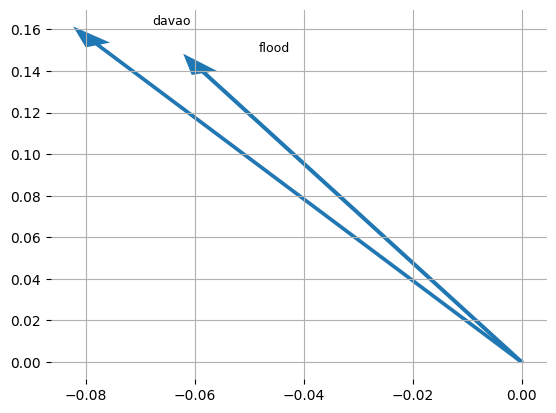

In [101]:
# Plot word vectors
def plot_vectors(vectors, words):
  # Create a figure and a 2D Axes
  fig, ax = plt.subplots()

  for word in words:
    # Get the vector for the word
    vector = vectors[word]

    # Plot the word near the arrow head
    ax.text(vector[0] + 0.01, vector[1] + 0.01, word, fontsize=9)
    # Plot the vector
    ax.arrow(
      0,                      # Start x
      0,                      # Start y
      vector[0],              # End x
      vector[1],              # End y
      # head_width=0.05,      # Arrow head width
      # head_length=0.1       # Arrow head length
      head_width=0.05 * 0.1,  # Arrow head width
      head_length=0.1 * 0.1,  # Arrow head length
      lw=0.01,                # Arrow line width
      # fc='r',                 # Arrow fill color
      # ec='r'                  # Arrow edge color
    )

  # Remove border around the plot
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)

  plt.grid()

  # Display the plot
  plt.show()


plot_vectors(vectors, vectors.index_to_key[:2])

## Plotting with Principal Component Analysis (PCA)

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [103]:
# Words most similar to 'dpwh'
vectors.most_similar('dpwh', topn=5)
word_set1 = [word for word, score in vectors.most_similar('dpwh', topn=5)]
word_set1

['alam', 'pilipinas', 'marcos', 'tao', 'corruption']

In [104]:
# Words most similar to 'scam'
vectors.most_similar('corruption', topn=5)
word_set2 = [word for word, score in vectors.most_similar('scam', topn=5)]
word_set2

['bicol', 'ilocos', 'court', 'kulong', 'mayor']

In [105]:
words_to_viz = word_set1 + word_set2
words_to_viz

['alam',
 'pilipinas',
 'marcos',
 'tao',
 'corruption',
 'bicol',
 'ilocos',
 'court',
 'kulong',
 'mayor']

In [106]:
vecs_to_viz = [vectors[word] for word in words_to_viz]
vecs_to_viz

[array([-0.05682225,  0.11552357,  0.03568579,  0.01163838,  0.00968606,
        -0.24441604,  0.03687   ,  0.3418177 , -0.06897055, -0.07597023,
        -0.05193107, -0.21549104, -0.03017761,  0.07790174,  0.04221651,
        -0.14548923, -0.03161932, -0.193215  ,  0.02026307, -0.29328236,
         0.09246738,  0.06500606,  0.12442054, -0.06146292, -0.01460444,
        -0.03606115, -0.0748688 , -0.10959199, -0.15987162, -0.04251678,
         0.17715174,  0.06805615,  0.04054462, -0.14619651, -0.02696597,
         0.17438777, -0.00266889, -0.13143757, -0.09053185, -0.31680852,
        -0.01121836, -0.1286166 , -0.02323163,  0.00944537,  0.13132739,
        -0.08636587, -0.13416871,  0.0083398 ,  0.06122099,  0.13034672,
         0.00982702, -0.13729638, -0.07678603, -0.03178796, -0.04326662,
         0.09801448,  0.05623811, -0.02582938, -0.13202964,  0.04375578,
         0.03345596,  0.07805806, -0.06920809,  0.03504569, -0.15583642,
         0.10294235,  0.01566095,  0.10331633, -0.1

In [107]:
pca = PCA(n_components=2)
vecs_PCA = pca.fit_transform(vecs_to_viz)
vecs_PCA

array([[ 0.31801297, -0.03258743],
       [ 0.29410953, -0.00836273],
       [ 0.31154338, -0.0168246 ],
       [ 0.288997  , -0.02347233],
       [ 0.27394211, -0.01293393],
       [-0.50640264,  0.0157801 ],
       [ 0.29116821,  0.10295385],
       [-0.58291901,  0.00429927],
       [-0.30320364, -0.02686315],
       [-0.3852479 , -0.00198906]])

In [108]:
vecs_PCA_df = pd.DataFrame(columns=['word', 'association', 'PC1', 'PC2'])

for idx in range(len(words_to_viz)):
  word = words_to_viz[idx]
  association = 'pogo' if word in word_set1 else 'scam'
  PC1 = vecs_PCA[idx, 0]
  PC2 = vecs_PCA[idx, 1]
  new_row = [word, association, PC1, PC2]

  vecs_PCA_df.loc[len(vecs_PCA_df)] = new_row

vecs_PCA_df

,word,association,PC1,PC2
0,alam,pogo,0.318013,-0.032587
1,pilipinas,pogo,0.294110,-0.008363
2,marcos,pogo,0.311543,-0.016825
3,tao,pogo,0.288997,-0.023472
4,corruption,pogo,0.273942,-0.012934
5,bicol,scam,-0.506403,0.015780
6,ilocos,scam,0.291168,0.102954
7,court,scam,-0.582919,0.004299
8,kulong,scam,-0.303204,-0.026863
9,mayor,scam,-0.385248,-0.001989


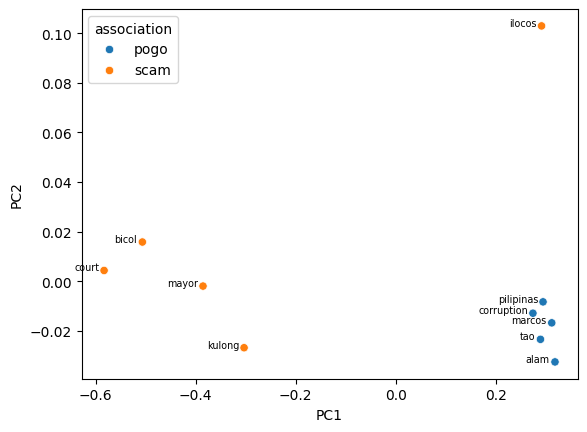

In [109]:
vecs_viz = sns.scatterplot(data=vecs_PCA_df, x='PC1', y='PC2', hue='association')
for idx in range(len(words_to_viz)):
  vecs_viz.text(vecs_PCA_df.PC1[idx] - 0.01, vecs_PCA_df.PC2[idx], vecs_PCA_df.word[idx], horizontalalignment='right',
                size='x-small', color='black', weight='light')
vecs_viz

plt.show()

In [110]:
def viz_associated_wordvecs(word1, word2, topn=5, model=vectors):
  word_set1 = [model.most_similar(word1, topn=topn)[idx][0] for idx in range(topn)]
  word_set2 = [model.most_similar(word2, topn=topn)[idx][0] for idx in range(topn)]
  words_to_viz = word_set1 + word_set2
  vecs_to_viz = [model[word] for word in words_to_viz]

  pca = PCA(n_components=2)
  vecs_PCA = pca.fit_transform(vecs_to_viz)
  vecs_PCA_df = pd.DataFrame(columns=['word', 'association', 'PC1', 'PC2'])

  for idx in range(len(words_to_viz)):
    word = words_to_viz[idx]
    association = word1 if word in word_set1 else word2
    PC1 = vecs_PCA[idx, 0]
    PC2 = vecs_PCA[idx, 1]
    new_row = [word, association, PC1, PC2]
    vecs_PCA_df.loc[len(vecs_PCA_df)] = new_row

  vecs_viz = sns.scatterplot(data=vecs_PCA_df, x='PC1', y='PC2', hue='association')

  for idx in range(len(words_to_viz)):
    vecs_viz.text(vecs_PCA_df.PC1[idx] - 0.01, vecs_PCA_df.PC2[idx], vecs_PCA_df.word[idx], horizontalalignment='right',
                  size='x-small', color='black', weight='light')
  return vecs_PCA_df

,word,association,PC1,PC2
0,projects,flood,-0.065456,-0.044143
1,ghost,flood,-0.050217,-0.077682
2,project,flood,0.044070,-0.085932
3,cebu,flood,0.038784,0.004205
4,davao,flood,0.162915,0.008840
5,ici,corruption,-0.016177,0.040892
6,duterte,corruption,-0.078309,0.056321
7,n,corruption,0.057356,0.048014
8,dpwh,corruption,-0.047468,0.018825
9,marcos,corruption,-0.045497,0.030660


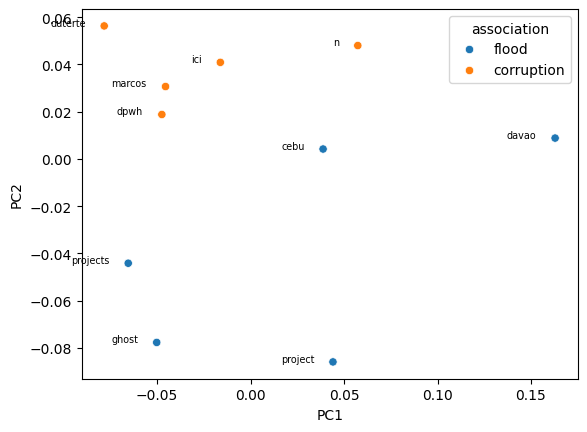

In [111]:
viz_associated_wordvecs('flood', 'corruption', topn=5, model=vectors)

In [112]:
!pip install transformers torch bertopic sentence-transformers umap-learn hdbscan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Libraries imported successfully!

BERT-based Topic Modeling


2025-11-15 13:16:27,156 - BERTopic - Embedding - Transforming documents to embeddings.


Number of documents for topic modeling: 2090


Batches: 100%|██████████| 66/66 [00:05<00:00, 12.05it/s]
2025-11-15 13:16:32,679 - BERTopic - Embedding - Completed ✓
2025-11-15 13:16:32,679 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-15 13:16:35,421 - BERTopic - Dimensionality - Completed ✓
2025-11-15 13:16:35,422 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-15 13:16:35,502 - BERTopic - Cluster - Completed ✓
2025-11-15 13:16:35,503 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-15 13:16:35,528 - BERTopic - Representation - Completed ✓
2025-11-15 13:16:35,528 - BERTopic - Topic reduction - Reducing number of topics
2025-11-15 13:16:35,532 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-15 13:16:35,553 - BERTopic - Representation - Completed ✓
2025-11-15 13:16:35,554 - BERTopic - Topic reduction - Reduced number of topics from 31 to 22


Number of topics discovered: 21

Top 10 Topics:
   Topic  Count                                     Name  \
0     -1    675                    -1_bayan_co_pera_sana   
1      0    548              0_ilocos_romualdez_davao_ur   
2      1    131         1_flood_control_project_projects   
3      2    124           2_law_kaso_ebidensya_ombudsman   
4      3     85  3_presidente_politiko_president_corrupt   
5      4     75   4_congressman_senador_senator_senators   
6      5     60          5_ghost_project_projects_daming   
7      6     55         6_project_davao_manila_pilipinas   
8      7     48          7_corruption_niyo_corrupt_funds   
9      8     48             8_billion_pera_money_ninakaw   

                                      Representation  \
0  [bayan, co, pera, sana, zaldy, davao, nag, ban...   
1  [ilocos, romualdez, davao, ur, god, talaga, co...   
2  [flood, control, project, projects, baha, cebu...   
3  [law, kaso, ebidensya, ombudsman, evidence, ar...   
4  [preside

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Analyzing sentiment for 1000 documents...
Processed 0/1000 documents...
Processed 100/1000 documents...
Processed 200/1000 documents...
Processed 300/1000 documents...
Processed 400/1000 documents...
Processed 500/1000 documents...
Processed 600/1000 documents...
Processed 700/1000 documents...
Processed 800/1000 documents...
Processed 900/1000 documents...

Sentiment Analysis Results:
sentiment
negative    633
positive    265
neutral     102
Name: count, dtype: int64

BERT-based Emotion Analysis


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Analyzing emotions for 500 documents...
Processed 0/500 documents...
Processed 50/500 documents...
Processed 100/500 documents...
Processed 150/500 documents...
Processed 200/500 documents...
Processed 250/500 documents...
Processed 300/500 documents...
Processed 350/500 documents...
Processed 400/500 documents...
Processed 450/500 documents...

Emotion Analysis Results:
emotion
neutral     384
joy          33
anger        30
sadness      23
fear         23
surprise      7
Name: count, dtype: int64

Analysis and Visualizations


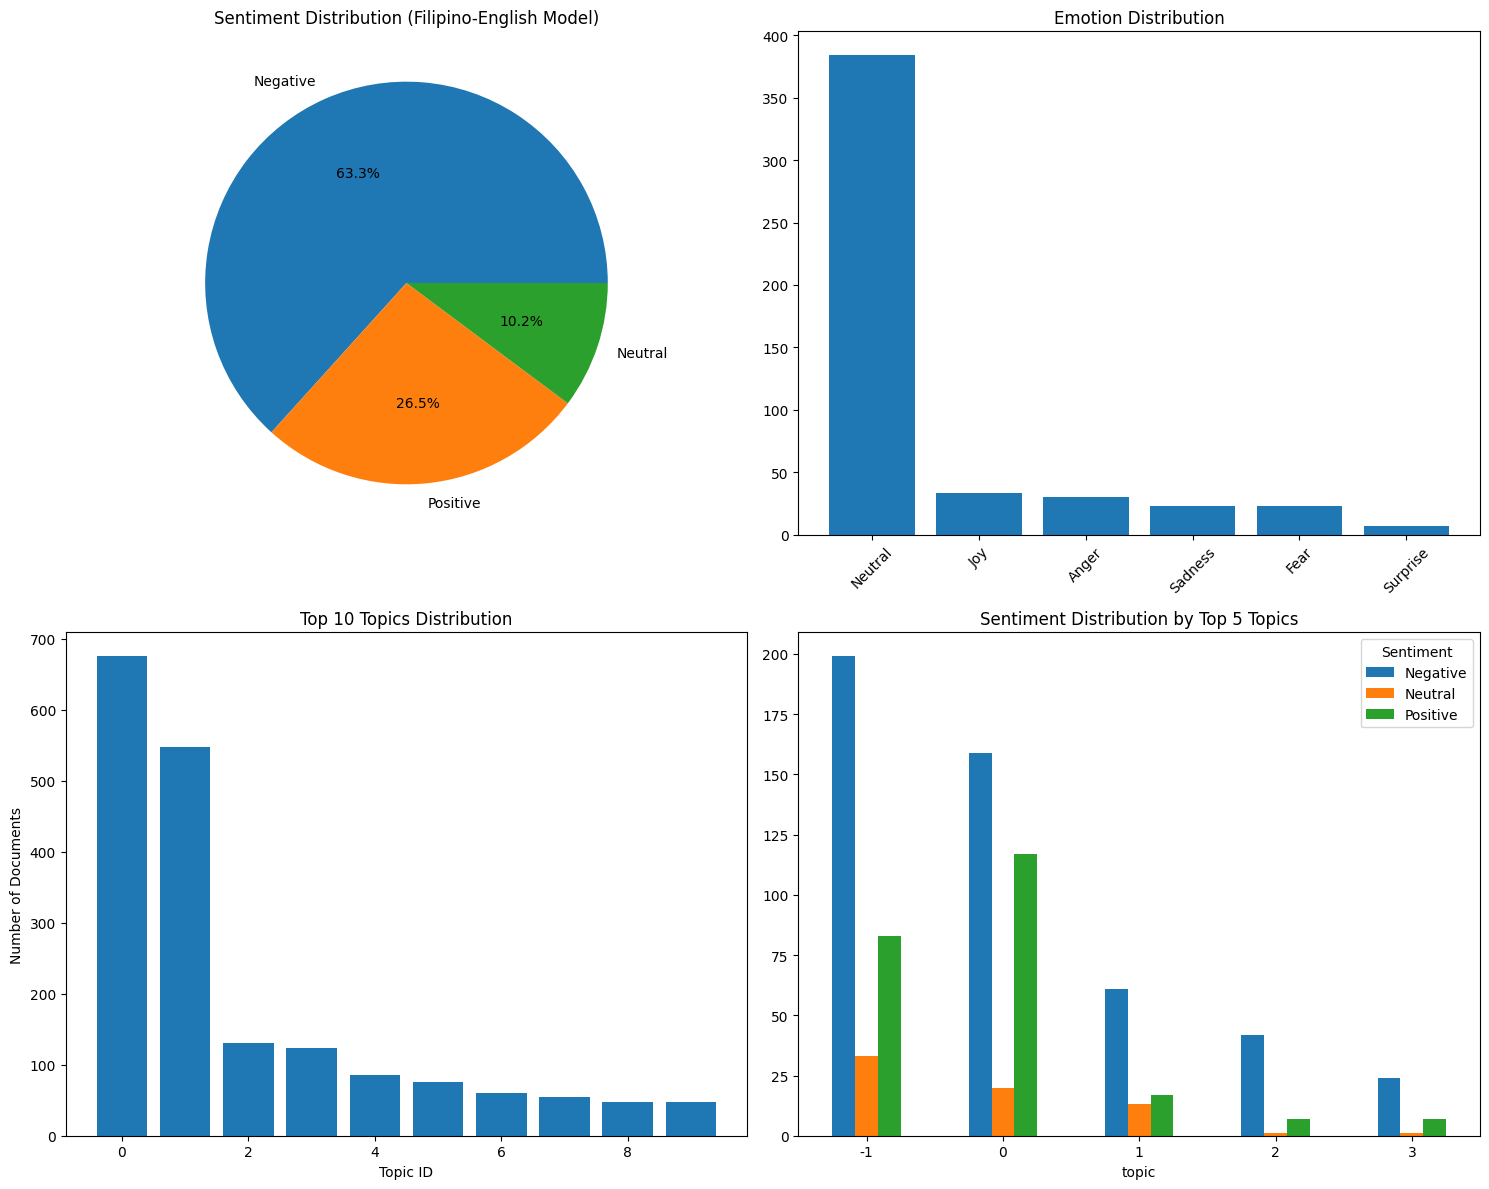


Summary Statistics and Insights
TOPIC-SENTIMENT ANALYSIS:

Topic -1 (Keywords: bayan, co, pera, sana, zaldy):
  Documents: 675
  Negative: 63.2%
  Positive: 26.3%
  Neutral: 10.5%

Topic 0 (Keywords: ilocos, romualdez, davao, ur, god):
  Documents: 548
  Negative: 53.7%
  Positive: 39.5%
  Neutral: 6.8%

Topic 1 (Keywords: flood, control, project, projects, baha):
  Documents: 131
  Negative: 67.0%
  Positive: 18.7%
  Neutral: 14.3%

Topic 2 (Keywords: law, kaso, ebidensya, ombudsman, evidence):
  Documents: 124
  Negative: 84.0%
  Positive: 14.0%
  Neutral: 2.0%

Topic 3 (Keywords: presidente, politiko, president, corrupt, hinde):
  Documents: 85
  Negative: 75.0%
  Positive: 21.9%
  Neutral: 3.1%

EMOTION-TOPIC ANALYSIS:

Topic -1 (Keywords: bayan, co, pera, sana, zaldy):
  Neutral: 78.5%
  Anger: 9.7%
  Sadness: 4.9%

Topic 0 (Keywords: ilocos, romualdez, davao, ur, god):
  Neutral: 82.7%
  Joy: 9.0%
  Sadness: 3.0%

Topic 1 (Keywords: flood, control, project, projects, baha):
  Ne

In [113]:
# Import necessary libraries
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

# BERT-based Topic Modeling using BERTopic
print("\n" + "="*50)
print("BERT-based Topic Modeling")
print("="*50)

# Initialize sentence transformer model for embeddings
sentence_model = SentenceTransformer('meedan/paraphrase-filipino-mpnet-base-v2')

# Initialize BERTopic model
topic_model = BERTopic(
    embedding_model=sentence_model,
    min_topic_size=10,  # Minimum number of documents per topic
    nr_topics="auto",   # Let the model decide the number of topics
    calculate_probabilities=True,
    verbose=True
)

# Prepare documents for topic modeling
documents = corpus['cleaned_text'].dropna().tolist()
print(f"Number of documents for topic modeling: {len(documents)}")

# Fit the topic model
topics, probabilities = topic_model.fit_transform(documents)

print(f"Number of topics discovered: {len(set(topics)) - 1}")  # -1 to exclude outlier topic

# Get topic information
topic_info = topic_model.get_topic_info()
print("\nTop 10 Topics:")
print(topic_info.head(10))

# Visualize topics
try:
    # Topic visualization (word clouds for top topics)
    fig = topic_model.visualize_barchart(top_k_topics=8, n_words=10, height=400)
    fig.show()
except:
    print("Visualization requires additional dependencies. Showing topic words instead.")
    for i in range(min(5, len(topic_info)-1)):
        topic_words = topic_model.get_topic(i)
        print(f"Topic {i}: {[word for word, _ in topic_words[:10]]}")

# Add topic assignments to the corpus dataframe
corpus_with_topics = corpus.copy()
corpus_with_topics = corpus_with_topics.dropna(subset=['cleaned_text']).reset_index(drop=True)
corpus_with_topics['topic'] = topics
corpus_with_topics['topic_probability'] = [max(prob) if prob is not None else 0 for prob in probabilities]

# Show topic distribution
topic_distribution = corpus_with_topics['topic'].value_counts().head(10)
print("\nTopic Distribution (Top 10):")
print(topic_distribution)

# BERT-based Sentiment Analysis
print("\n" + "="*50)
print("BERT-based Sentiment Analysis")
print("="*50)

# Initialize sentiment analysis pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="dost-asti/RoBERTa-tl-sentiment-analysis",
    return_all_scores=True
)

# Function to get sentiment scores
def get_sentiment_scores(text, max_length=512):
    try:
        # Truncate text if it's too long
        if len(text) > max_length:
            text = text[:max_length]

        results = sentiment_pipeline(text)[0]

        # Label mapping for different model outputs
        label_map = {
            'LABEL_0': 'negative',
            'LABEL_1': 'neutral', 
            'LABEL_2': 'positive',
            'negative': 'negative',
            'neutral': 'neutral',
            'positive': 'positive'
        }

        # Extract scores with proper label mapping
        sentiment_scores = {}
        for result in results:
            original_label = result['label']
            mapped_label = label_map.get(original_label, original_label.lower())
            sentiment_scores[mapped_label] = result['score']

        # Get the dominant sentiment
        dominant_sentiment = max(sentiment_scores.items(), key=lambda x: x[1])

        return {
            'sentiment': dominant_sentiment[0],
            'confidence': dominant_sentiment[1],
            'negative_score': sentiment_scores.get('negative', 0),
            'neutral_score': sentiment_scores.get('neutral', 0),
            'positive_score': sentiment_scores.get('positive', 0)
        }
    except Exception as e:
        print(f"Error processing text: {e}")
        return {
            'sentiment': 'neutral',
            'confidence': 0,
            'negative_score': 0,
            'neutral_score': 1,
            'positive_score': 0
        }

# Apply sentiment analysis to a sample of documents (to avoid API limits)
sample_size = min(1000, len(corpus_with_topics))  # Analyze first 1000 documents
print(f"Analyzing sentiment for {sample_size} documents...")

sentiment_results = []
for i, text in enumerate(corpus_with_topics['cleaned_text'].head(sample_size)):
    if i % 100 == 0:
        print(f"Processed {i}/{sample_size} documents...")

    result = get_sentiment_scores(str(text))
    sentiment_results.append(result)

# Create sentiment dataframe
sentiment_df = pd.DataFrame(sentiment_results)
print("\nSentiment Analysis Results:")
print(sentiment_df['sentiment'].value_counts())

# Add sentiment results to corpus
corpus_with_topics.loc[:sample_size-1, 'sentiment'] = sentiment_df['sentiment'].values
corpus_with_topics.loc[:sample_size-1, 'sentiment_confidence'] = sentiment_df['confidence'].values
corpus_with_topics.loc[:sample_size-1, 'negative_score'] = sentiment_df['negative_score'].values
corpus_with_topics.loc[:sample_size-1, 'neutral_score'] = sentiment_df['neutral_score'].values
corpus_with_topics.loc[:sample_size-1, 'positive_score'] = sentiment_df['positive_score'].values

# BERT-based Emotion Analysis
print("\n" + "="*50)
print("BERT-based Emotion Analysis")
print("="*50)

# Initialize emotion analysis pipeline
emotion_pipeline = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True
)

# Function to get emotion scores
def get_emotion_scores(text, max_length=512):
    try:
        # Truncate text if it's too long
        if len(text) > max_length:
            text = text[:max_length]

        results = emotion_pipeline(text)[0]

        # Extract scores (labels are already lowercase)
        emotion_scores = {result['label']: result['score'] for result in results}

        # Get the dominant emotion
        dominant_emotion = max(emotion_scores.items(), key=lambda x: x[1])

        return {
            'emotion': dominant_emotion[0],
            'emotion_confidence': dominant_emotion[1],
            **emotion_scores
        }
    except Exception as e:
        print(f"Error processing text for emotion: {e}")
        return {
            'emotion': 'neutral',
            'emotion_confidence': 0,
            'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'neutral': 1, 'sadness': 0, 'surprise': 0
        }

# Apply emotion analysis to a smaller sample
emotion_sample_size = min(500, len(corpus_with_topics))  # Analyze first 500 documents
print(f"Analyzing emotions for {emotion_sample_size} documents...")

emotion_results = []
for i, text in enumerate(corpus_with_topics['cleaned_text'].head(emotion_sample_size)):
    if i % 50 == 0:
        print(f"Processed {i}/{emotion_sample_size} documents...")

    result = get_emotion_scores(str(text))
    emotion_results.append(result)

# Create emotion dataframe
emotion_df = pd.DataFrame(emotion_results)
print("\nEmotion Analysis Results:")
print(emotion_df['emotion'].value_counts())

# Add emotion results to corpus
corpus_with_topics.loc[:emotion_sample_size-1, 'emotion'] = emotion_df['emotion'].values
corpus_with_topics.loc[:emotion_sample_size-1, 'emotion_confidence'] = emotion_df['emotion_confidence'].values

# Add individual emotion scores
emotion_cols = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
for col in emotion_cols:
    if col in emotion_df.columns:
        corpus_with_topics.loc[:emotion_sample_size-1, f'emotion_{col}'] = emotion_df[col].values

# Analysis and Visualizations
print("\n" + "="*50)
print("Analysis and Visualizations")
print("="*50)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sentiment Distribution
sentiment_counts = corpus_with_topics['sentiment'].value_counts()
# Capitalize labels for better display
display_labels = [label.capitalize() for label in sentiment_counts.index]
axes[0, 0].pie(sentiment_counts.values, labels=display_labels, autopct='%1.1f%%')
axes[0, 0].set_title('Sentiment Distribution (Filipino-English Model)')

# Emotion Distribution
emotion_counts = corpus_with_topics['emotion'].value_counts()
# Capitalize labels for better display
display_emotion_labels = [label.capitalize() for label in emotion_counts.index]
axes[0, 1].bar(display_emotion_labels, emotion_counts.values)
axes[0, 1].set_title('Emotion Distribution')
axes[0, 1].tick_params(axis='x', rotation=45)

# Topic Distribution (Top 10)
topic_counts = corpus_with_topics['topic'].value_counts().head(10)
axes[1, 0].bar(range(len(topic_counts)), topic_counts.values)
axes[1, 0].set_title('Top 10 Topics Distribution')
axes[1, 0].set_xlabel('Topic ID')
axes[1, 0].set_ylabel('Number of Documents')

# Sentiment vs Topic (for top 5 topics)
if 'sentiment' in corpus_with_topics.columns and 'topic' in corpus_with_topics.columns:
    top_topics = corpus_with_topics['topic'].value_counts().head(5).index
    topic_sentiment_data = corpus_with_topics[corpus_with_topics['topic'].isin(top_topics)]

    sentiment_topic_crosstab = pd.crosstab(topic_sentiment_data['topic'], topic_sentiment_data['sentiment'])
    # Rename columns to capitalize for display
    sentiment_topic_crosstab.columns = [col.capitalize() for col in sentiment_topic_crosstab.columns]
    sentiment_topic_crosstab.plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Sentiment Distribution by Top 5 Topics')
    axes[1, 1].tick_params(axis='x', rotation=0)
    axes[1, 1].legend(title='Sentiment')

plt.tight_layout()
plt.show()

# Summary Statistics and Insights
print("\n" + "="*50)
print("Summary Statistics and Insights")
print("="*50)

# Topic-Sentiment Analysis
print("TOPIC-SENTIMENT ANALYSIS:")
if 'sentiment' in corpus_with_topics.columns:
    for topic_id in topic_counts.head(5).index:
        topic_data = corpus_with_topics[corpus_with_topics['topic'] == topic_id]
        sentiment_dist = topic_data['sentiment'].value_counts(normalize=True) * 100

        # Get topic words
        topic_words = topic_model.get_topic(topic_id)
        top_words = [word for word, _ in topic_words[:5]]

        print(f"\nTopic {topic_id} (Keywords: {', '.join(top_words)}):")
        print(f"  Documents: {len(topic_data)}")
        for sentiment, percentage in sentiment_dist.items():
            print(f"  {sentiment.capitalize()}: {percentage:.1f}%")

# Emotion-Topic Analysis
print("\nEMOTION-TOPIC ANALYSIS:")
if 'emotion' in corpus_with_topics.columns:
    for topic_id in topic_counts.head(3).index:
        topic_data = corpus_with_topics[corpus_with_topics['topic'] == topic_id]
        emotion_dist = topic_data['emotion'].value_counts(normalize=True) * 100

        topic_words = topic_model.get_topic(topic_id)
        top_words = [word for word, _ in topic_words[:5]]

        print(f"\nTopic {topic_id} (Keywords: {', '.join(top_words)}):")
        for emotion, percentage in emotion_dist.head(3).items():
            print(f"  {emotion.capitalize()}: {percentage:.1f}%")

# Save results
print(f"\nSaving results...")
corpus_with_topics.to_csv('corpus_with_bert_analysis.csv', index=False)
print("Results saved to 'corpus_with_bert_analysis.csv'")

# Display sample results
print("\nSample Results:")
columns_to_show = ['cleaned_text', 'topic', 'sentiment', 'emotion', 'sentiment_confidence', 'emotion_confidence']
available_columns = [col for col in columns_to_show if col in corpus_with_topics.columns]
print(corpus_with_topics[available_columns].head())

print("\nBERT Analysis Complete!")
print(f"Total documents analyzed: {len(corpus_with_topics)}")
print(f"Topics discovered: {len(set(topics)) - 1}")
print(f"Documents with sentiment analysis: {corpus_with_topics['sentiment'].notna().sum()}")
print(f"Documents with emotion analysis: {corpus_with_topics['emotion'].notna().sum()}")